<a href="https://colab.research.google.com/github/chacacaliza/Malaria-Classification/blob/main/Malaria_Classification_CNN_2_Skripsi_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KLASIFIKASI PENYAKIT MALARIA DENGAN METODE CNN**

**Arsitektur model CNN yang diusulkan menggunakan 4 convolutional layer + 1 fully connected layer**

# Scenario 1 Splitting 75 : 25%

Skenario Pengujian 1 menggunakan splitting data 75 : 25% (Berdasarkan jurnal Acuan) dengan optimizer RMSProp

In [ ]:
!git clone https://github.com/chacacaliza/Malaria-Classification.git

Cloning into 'Malaria-Classification'...
remote: Enumerating objects: 27571, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 27571 (delta 1), reused 6 (delta 1), pack-reused 27565
Receiving objects: 100% (27571/27571), 331.87 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (27561/27561), done.


In [ ]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/train/"
TEST_DIR ="/content/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(TEST_DIR)

for label in ['Uninfected', 'Parasitized']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(TEST_DIR+label)

Splitting Data

In [ ]:
import random
def train_valid_test_split(source, train_dir, test_dir,train_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-train_size))
    test_size = int(len(files) * (train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)    
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/Malaria-Classification/Dataset/"

for label in ['Uninfected', 'Parasitized']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', TEST_DIR +label+'/', train_size=0.75, test_size=0.25)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

Uninfected
10335
3445
Parasitized
10335
3445


Preprocessing

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
        )

Found 20668 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
)

Found 6890 images belonging to 2 classes.


Model CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Print model summary
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                        

Training Model

Pada penelitian ini data Test juga digunakan sebagai Data Validation saat training epoch

In [ ]:
history1 = model1.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
646/646 [==============================] - 64s 77ms/step - loss: 0.2756 - acc: 0.8982 - val_loss: 0.1995 - val_acc: 0.9412
Epoch 2/100
646/646 [==============================] - 51s 79ms/step - loss: 0.1543 - acc: 0.9503 - val_loss: 0.1807 - val_acc: 0.9374
Epoch 3/100
646/646 [==============================] - 49s 76ms/step - loss: 0.1458 - acc: 0.9524 - val_loss: 0.1357 - val_acc: 0.9581
Epoch 4/100
646/646 [==============================] - 49s 76ms/step - loss: 0.1369 - acc: 0.9557 - val_loss: 0.1374 - val_acc: 0.9553
Epoch 5/100
646/646 [==============================] - 50s 77ms/step - loss: 0.1342 - acc: 0.9558 - val_loss: 0.1284 - val_acc: 0.9573
Epoch 6/100
646/646 [==============================] - 49s 76ms/step - loss: 0.1296 - acc: 0.9558 - val_loss: 0.1231 - val_acc: 0.9623
Epoch 7/100
646/646 [==============================] - 49s 76ms/step - loss: 0.1265 - acc: 0.9580 - val_loss: 0.1356 - val_acc: 0.9553
Epoch 8/100
646/646 [==============================] - 

In [ ]:
model1.evaluate_generator(test_generator, verbose=1)

  3/216 [..............................] - ETA: 7s - loss: 0.2362 - acc: 0.9375 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


216/216 [==============================] - 8s 35ms/step - loss: 0.1073 - acc: 0.9673


[0.10729283839464188, 0.9673439860343933]

In [ ]:
print("Train Accuracy : ")
model1.evaluate(train_generator)

Train Accuracy : 
646/646 [==============================] - 44s 68ms/step - loss: 0.0761 - acc: 0.9751


[0.0760602131485939, 0.9751306176185608]

In [ ]:
print("Test Accuracy : ")
model1.evaluate(test_generator)

Test Accuracy : 
216/216 [==============================] - 8s 37ms/step - loss: 0.1073 - acc: 0.9673


[0.10729285329580307, 0.9673439860343933]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model1):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model1.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("recall of the model is ", recall)
  print("precision of the model is ", precision)
  print("F1-Score of the model is ", f)

Found 6890 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



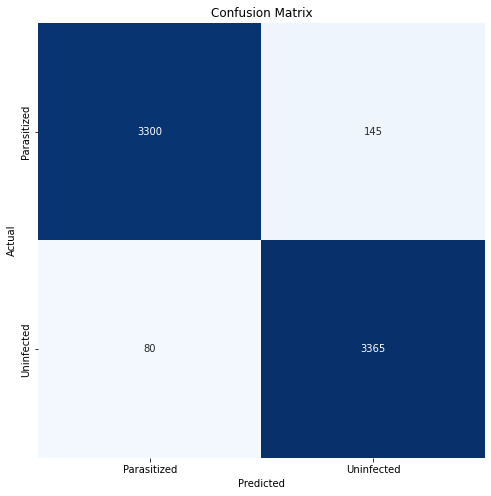



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      3445
  Uninfected       0.96      0.98      0.97      3445

    accuracy                           0.97      6890
   macro avg       0.97      0.97      0.97      6890
weighted avg       0.97      0.97      0.97      6890

recall of the model is  0.97677793904209
precision of the model is  0.9586894586894587
F1-Score of the model is  0.9676491732566498


In [ ]:
evaluate(model1)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history1):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history1.history['acc']
  val_acc = history1.history['val_acc']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy1 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history1.history['loss']
  val_loss = history1.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss1 Plot.svg", format="svg", dpi=1200)

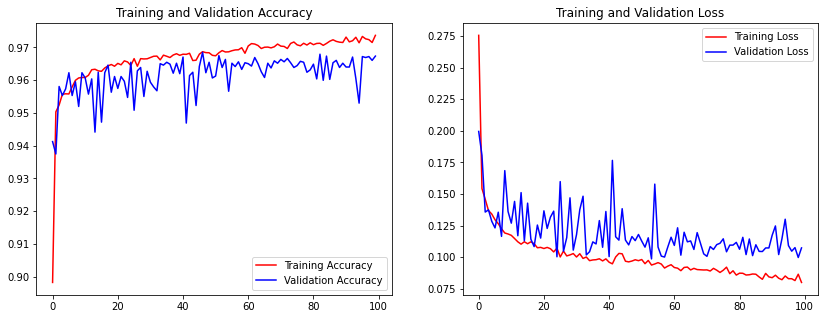

In [ ]:
eval_plot(history1)

In [ ]:
model1.save_weights("Model1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# serialize model to JSON
model1_json = model1.to_json()
with open("Model1.json", "w") as json_file: json_file.write(model1_json)

In [ ]:
# serialize weights to HDF5
model1.save("Model1.h5")
print("Saved model to disk")

Saved model to disk


# Scenario 2 Splitting 80 : 20%

Skenario pengujian 2 menggunakan splitting data 80 : 20% dengan optimizer RMSprop

In [ ]:
!git clone https://github.com/chacacaliza/Malaria-Classification.git

Cloning into 'Malaria-Classification'...
remote: Enumerating objects: 27571, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 27571 (delta 1), reused 6 (delta 1), pack-reused 27565
Receiving objects: 100% (27571/27571), 331.87 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (27561/27561), done.


In [ ]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/train/"
TEST_DIR ="/content/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(TEST_DIR)

for label in ['Uninfected', 'Parasitized']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(TEST_DIR+label)

In [ ]:
import random
def train_valid_test_split(source, train_dir, test_dir,train_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-train_size))
    test_size = int(len(files) * (train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)    
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/Malaria-Classification/Dataset/"

for label in ['Uninfected', 'Parasitized']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, test_size=0.2)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

Uninfected
11025
2755
Parasitized
11025
2755


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
        )

Found 22049 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(
      rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
)

Found 5509 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Print model summary
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
history1 = model1.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


689/689 [==============================] - 71s 84ms/step - loss: 0.2953 - acc: 0.8874 - val_loss: 0.2025 - val_acc: 0.9298
Epoch 2/100
689/689 [==============================] - 52s 75ms/step - loss: 0.1691 - acc: 0.9462 - val_loss: 0.1659 - val_acc: 0.9416
Epoch 3/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1479 - acc: 0.9517 - val_loss: 0.1205 - val_acc: 0.9601
Epoch 4/100
689/689 [==============================] - 51s 74ms/step - loss: 0.1459 - acc: 0.9529 - val_loss: 0.1662 - val_acc: 0.9505
Epoch 5/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1404 - acc: 0.9532 - val_loss: 0.1587 - val_acc: 0.9470
Epoch 6/100
689/689 [==============================] - 51s 74ms/step - loss: 0.1353 - acc: 0.9572 - val_loss: 0.1310 - val_acc: 0.9555
Epoch 7/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1321 - acc: 0.9551 - val_loss: 0.1227 - val_acc: 0.9603
Epoch 8/100
689/689 [==============================] - 51s 74ms/ste

In [ ]:
model1.evaluate_generator(test_generator, verbose=1)

  3/173 [..............................] - ETA: 5s - loss: 0.0535 - acc: 0.9896 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


173/173 [==============================] - 5s 31ms/step - loss: 0.0880 - acc: 0.9699


[0.08800936490297318, 0.9698729515075684]

In [ ]:
print("Train Accuracy : ")
model1.evaluate(train_generator)

Train Accuracy : 
689/689 [==============================] - 42s 62ms/step - loss: 0.0800 - acc: 0.9742


[0.08004247397184372, 0.9742380380630493]

In [ ]:
print("Test Accuracy : ")
model1.evaluate(test_generator)

Test Accuracy : 
173/173 [==============================] - 5s 31ms/step - loss: 0.0880 - acc: 0.9699


[0.08800939470529556, 0.9698729515075684]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model1):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model1.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("recall of the model is ", recall)
  print("precision of the model is ", precision)
  print("F1-Score of the model is ", f)

Found 5510 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



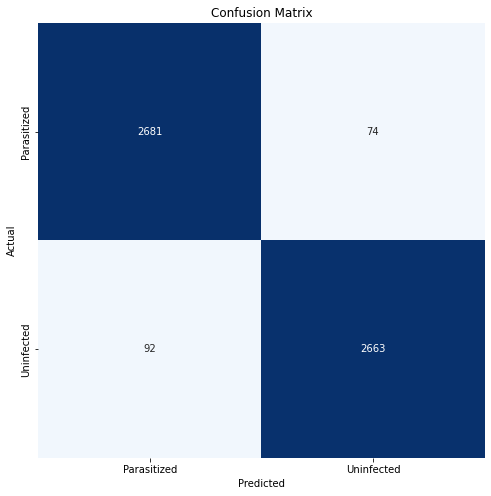



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.97      0.97      0.97      2755
  Uninfected       0.97      0.97      0.97      2755

    accuracy                           0.97      5510
   macro avg       0.97      0.97      0.97      5510
weighted avg       0.97      0.97      0.97      5510

recall of the model is  0.9666061705989111
precision of the model is  0.9729630982827914
F1-Score of the model is  0.9697742170429717


In [ ]:
evaluate(model1)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history1):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history1.history['acc']
  val_acc = history1.history['val_acc']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy1 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history1.history['loss']
  val_loss = history1.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss1 Plot.svg", format="svg", dpi=1200)

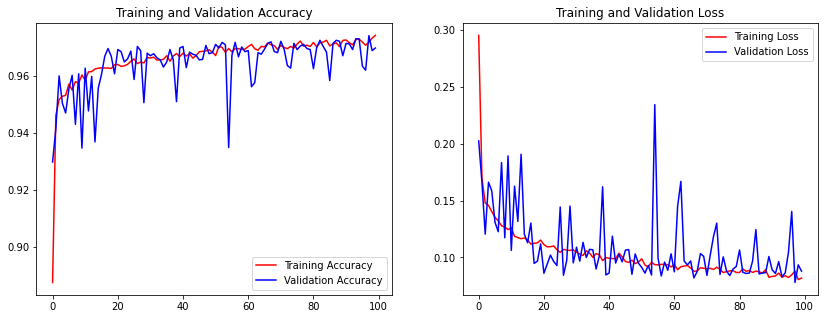

In [ ]:
eval_plot(history1)

In [ ]:
model1.save_weights("Model1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# serialize model to JSON
model1_json = model1.to_json()
with open("Model1.json", "w") as json_file: json_file.write(model1_json)

In [ ]:
# serialize weights to HDF5
model1.save("Model1.h5")
print("Saved model to disk")

Saved model to disk


# Skenario 3 Pengujian Optimizer

Skenario pengujian 3 menggunakan splitting data yang menghasilkan akurasi terbaik diantara skenario 1 dan 2. 
Skenario yang lebih unggul adalah skenario 2 yaitu dengan splitting data 80 : 20 %. Optimizer yang digunakan pada skenario ke 3 adalah Adam dan RMSprop

**AKURASI -> RMSprop= 97.01 % : ADAM= 97.42 %**

**Optimizer RMSProp**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# Print model summary
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
history1 = model1.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


689/689 [==============================] - 71s 84ms/step - loss: 0.2953 - acc: 0.8874 - val_loss: 0.2025 - val_acc: 0.9298
Epoch 2/100
689/689 [==============================] - 52s 75ms/step - loss: 0.1691 - acc: 0.9462 - val_loss: 0.1659 - val_acc: 0.9416
Epoch 3/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1479 - acc: 0.9517 - val_loss: 0.1205 - val_acc: 0.9601
Epoch 4/100
689/689 [==============================] - 51s 74ms/step - loss: 0.1459 - acc: 0.9529 - val_loss: 0.1662 - val_acc: 0.9505
Epoch 5/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1404 - acc: 0.9532 - val_loss: 0.1587 - val_acc: 0.9470
Epoch 6/100
689/689 [==============================] - 51s 74ms/step - loss: 0.1353 - acc: 0.9572 - val_loss: 0.1310 - val_acc: 0.9555
Epoch 7/100
689/689 [==============================] - 50s 73ms/step - loss: 0.1321 - acc: 0.9551 - val_loss: 0.1227 - val_acc: 0.9603
Epoch 8/100
689/689 [==============================] - 51s 74ms/ste

In [ ]:
model1.evaluate_generator(test_generator, verbose=1)

  3/173 [..............................] - ETA: 5s - loss: 0.0535 - acc: 0.9896 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


173/173 [==============================] - 5s 31ms/step - loss: 0.0880 - acc: 0.9699


[0.08800936490297318, 0.9698729515075684]

In [ ]:
print("Train Accuracy : ")
model1.evaluate(train_generator)

Train Accuracy : 
689/689 [==============================] - 42s 62ms/step - loss: 0.0800 - acc: 0.9742


[0.08004247397184372, 0.9742380380630493]

In [ ]:
print("Test Accuracy : ")
model1.evaluate(test_generator)

Test Accuracy : 
173/173 [==============================] - 5s 31ms/step - loss: 0.0880 - acc: 0.9699


[0.08800939470529556, 0.9698729515075684]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model1):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model1.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("recall of the model is ", recall)
  print("precision of the model is ", precision)
  print("F1-Score of the model is ", f)

Found 5510 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



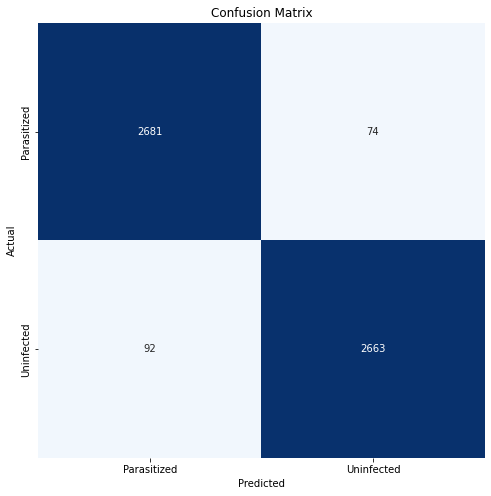



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.97      0.97      0.97      2755
  Uninfected       0.97      0.97      0.97      2755

    accuracy                           0.97      5510
   macro avg       0.97      0.97      0.97      5510
weighted avg       0.97      0.97      0.97      5510

recall of the model is  0.9666061705989111
precision of the model is  0.9729630982827914
F1-Score of the model is  0.9697742170429717


In [ ]:
evaluate(model1)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history1):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history1.history['acc']
  val_acc = history1.history['val_acc']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy1 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history1.history['loss']
  val_loss = history1.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss1 Plot.svg", format="svg", dpi=1200)

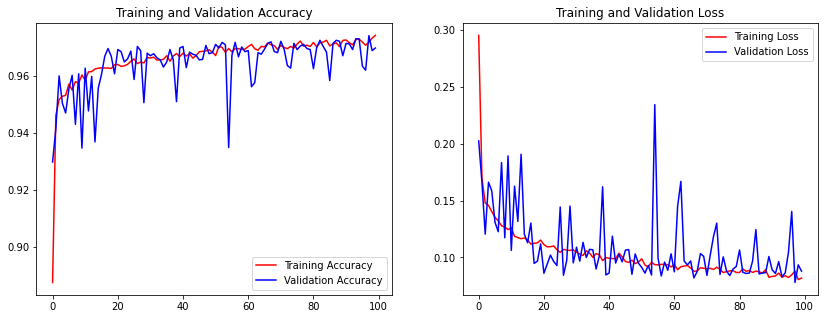

In [ ]:
eval_plot(history1)

**Optimizer Adam**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Print model summary
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
history2 = model2.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


689/689 [==============================] - 53s 75ms/step - loss: 0.2634 - acc: 0.8962 - val_loss: 0.1406 - val_acc: 0.9546
Epoch 2/100
689/689 [==============================] - 50s 72ms/step - loss: 0.1547 - acc: 0.9474 - val_loss: 0.1783 - val_acc: 0.9343
Epoch 3/100
689/689 [==============================] - 48s 70ms/step - loss: 0.1470 - acc: 0.9514 - val_loss: 0.2055 - val_acc: 0.9279
Epoch 4/100
689/689 [==============================] - 49s 70ms/step - loss: 0.1441 - acc: 0.9518 - val_loss: 0.1879 - val_acc: 0.9352
Epoch 5/100
689/689 [==============================] - 49s 71ms/step - loss: 0.1351 - acc: 0.9531 - val_loss: 0.1234 - val_acc: 0.9552
Epoch 6/100
689/689 [==============================] - 49s 70ms/step - loss: 0.1325 - acc: 0.9551 - val_loss: 0.1208 - val_acc: 0.9608
Epoch 7/100
689/689 [==============================] - 52s 76ms/step - loss: 0.1308 - acc: 0.9552 - val_loss: 0.1140 - val_acc: 0.9581
Epoch 8/100
689/689 [==============================] - 49s 70ms/ste

In [ ]:
model2.evaluate_generator(test_generator, verbose=1)

  3/173 [..............................] - ETA: 5s - loss: 0.1299 - acc: 0.9792 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


173/173 [==============================] - 5s 31ms/step - loss: 0.0857 - acc: 0.9742


[0.08571338653564453, 0.9742286801338196]

In [ ]:
print("Train Accuracy : ")
model2.evaluate(train_generator)

Train Accuracy : 
689/689 [==============================] - 42s 61ms/step - loss: 0.0720 - acc: 0.9758


[0.07195986807346344, 0.9758254885673523]

In [ ]:
print("Test Accuracy : ")
model2.evaluate(test_generator)

Test Accuracy : 
173/173 [==============================] - 5s 31ms/step - loss: 0.0857 - acc: 0.9742


[0.08571340143680573, 0.9742286801338196]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model2):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model2.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 5509 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



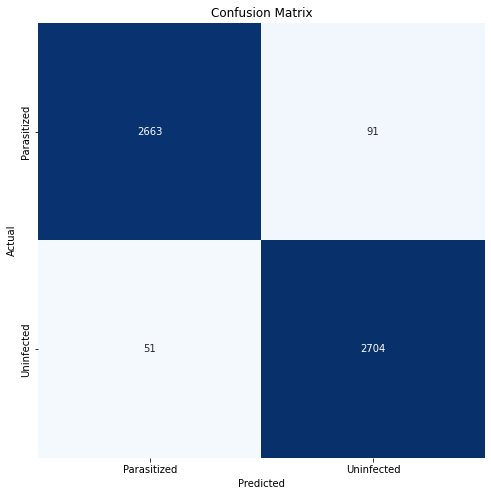



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2754
  Uninfected       0.97      0.98      0.97      2755

    accuracy                           0.97      5509
   macro avg       0.97      0.97      0.97      5509
weighted avg       0.97      0.97      0.97      5509

recall of the model is  0.9814882032667877
precision of the model is  0.9674418604651163
F1-Score of the model is  0.9744144144144143


In [ ]:
evaluate(model2)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history2):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history2.history['acc']
  val_acc = history2.history['val_acc']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy2 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history2.history['loss']
  val_loss = history2.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss2 Plot.svg", format="svg", dpi=1200)

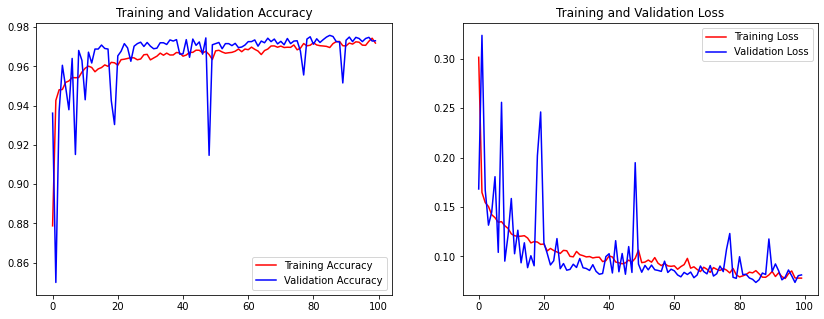

In [ ]:
eval_plot(history2)

# Skenario 4 Model CNN : Pretrained

Skenario pengujian 4 yaitu membandingkan model CNN yang menghasilkan akurasi terbaik diantara 3 skenario sebelumnya dengan pretrained VGG-19.
Skenario 3 dengan Adam optimizer terbukti menghasilkan akurasi yang paling unggul sehingga skenario 3 akan dibandingkan dengan VGG-19.

**AKURASI -> CNN= 97.42% : VGG-19= 93.12%**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Print model summary
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
history2 = model2.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


689/689 [==============================] - 53s 75ms/step - loss: 0.2634 - acc: 0.8962 - val_loss: 0.1406 - val_acc: 0.9546
Epoch 2/100
689/689 [==============================] - 50s 72ms/step - loss: 0.1547 - acc: 0.9474 - val_loss: 0.1783 - val_acc: 0.9343
Epoch 3/100
689/689 [==============================] - 48s 70ms/step - loss: 0.1470 - acc: 0.9514 - val_loss: 0.2055 - val_acc: 0.9279
Epoch 4/100
689/689 [==============================] - 49s 70ms/step - loss: 0.1441 - acc: 0.9518 - val_loss: 0.1879 - val_acc: 0.9352
Epoch 5/100
689/689 [==============================] - 49s 71ms/step - loss: 0.1351 - acc: 0.9531 - val_loss: 0.1234 - val_acc: 0.9552
Epoch 6/100
689/689 [==============================] - 49s 70ms/step - loss: 0.1325 - acc: 0.9551 - val_loss: 0.1208 - val_acc: 0.9608
Epoch 7/100
689/689 [==============================] - 52s 76ms/step - loss: 0.1308 - acc: 0.9552 - val_loss: 0.1140 - val_acc: 0.9581
Epoch 8/100
689/689 [==============================] - 49s 70ms/ste

In [ ]:
model2.evaluate_generator(test_generator, verbose=1)

  3/173 [..............................] - ETA: 5s - loss: 0.1299 - acc: 0.9792 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


173/173 [==============================] - 5s 31ms/step - loss: 0.0857 - acc: 0.9742


[0.08571338653564453, 0.9742286801338196]

In [ ]:
print("Train Accuracy : ")
model2.evaluate(train_generator)

Train Accuracy : 
689/689 [==============================] - 42s 61ms/step - loss: 0.0720 - acc: 0.9758


[0.07195986807346344, 0.9758254885673523]

In [ ]:
print("Test Accuracy : ")
model2.evaluate(test_generator)

Test Accuracy : 
173/173 [==============================] - 5s 31ms/step - loss: 0.0857 - acc: 0.9742


[0.08571340143680573, 0.9742286801338196]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model2):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model2.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 5509 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



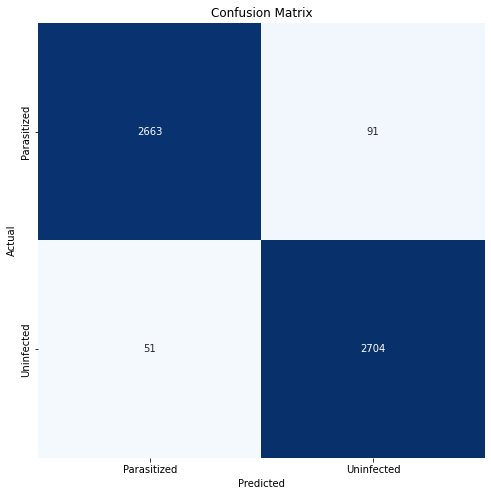



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2754
  Uninfected       0.97      0.98      0.97      2755

    accuracy                           0.97      5509
   macro avg       0.97      0.97      0.97      5509
weighted avg       0.97      0.97      0.97      5509

recall of the model is  0.9814882032667877
precision of the model is  0.9674418604651163
F1-Score of the model is  0.9744144144144143


In [ ]:
evaluate(model2)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history2):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history2.history['acc']
  val_acc = history2.history['val_acc']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy2 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history2.history['loss']
  val_loss = history2.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss2 Plot.svg", format="svg", dpi=1200)

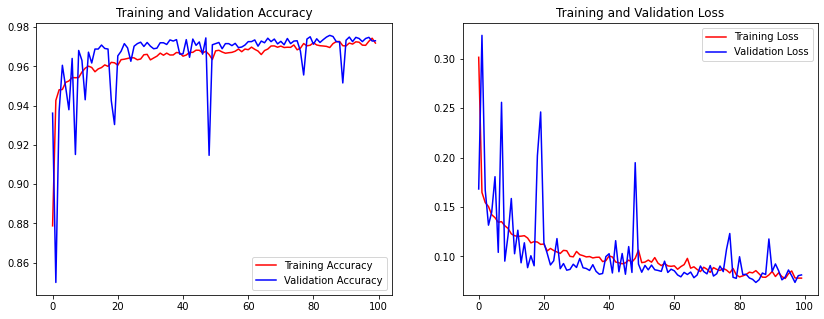

In [ ]:
eval_plot(history2)

**VGG-19**

In [ ]:
!git clone https://github.com/chacacaliza/Malaria-Classification.git

Cloning into 'Malaria-Classification'...
remote: Enumerating objects: 27571, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 27571 (delta 1), reused 6 (delta 1), pack-reused 27565
Receiving objects: 100% (27571/27571), 331.87 MiB | 45.06 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (27561/27561), done.


In [ ]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/train/"
TEST_DIR ="/content/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(TEST_DIR)

for label in ['Uninfected', 'Parasitized']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(TEST_DIR+label)

In [ ]:
import random
def train_valid_test_split(source, train_dir, test_dir,train_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-train_size))
    test_size = int(len(files) * (train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)    
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/Malaria-Classification/Dataset/"

for label in ['Uninfected', 'Parasitized']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, test_size=0.2)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

Uninfected
11025
2755
Parasitized
11025
2755


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        shear_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        )

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
        )

Found 22049 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (64, 64),
        batch_size=32,
        color_mode='rgb',
        class_mode = 'binary',
        shuffle=True,
)

Found 5509 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB5
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout, BatchNormalization
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [ ]:
classifier_vgg19 = VGG19(input_shape= (64,64,3),include_top=False,weights='imagenet')

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in classifier_vgg19.layers:
    layer.trainable = False

In [ ]:
classifier1 = classifier_vgg19.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=512, activation='relu')(classifier1)
classifier1 = Dropout(0.1)(classifier1)
classifier1 = BatchNormalization()(classifier1)
classifier1 = Dense(units=1, activation='sigmoid')(classifier1)

model2 = Model(inputs = classifier_vgg19.input , outputs = classifier1)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
history2 = model2.fit_generator(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


690/690 [==============================] - 56s 80ms/step - loss: 0.3057 - accuracy: 0.8738 - val_loss: 0.2601 - val_accuracy: 0.9118
Epoch 2/100
690/690 [==============================] - 56s 81ms/step - loss: 0.2710 - accuracy: 0.8926 - val_loss: 0.4498 - val_accuracy: 0.7869
Epoch 3/100
690/690 [==============================] - 56s 81ms/step - loss: 0.2525 - accuracy: 0.9012 - val_loss: 0.2243 - val_accuracy: 0.9118
Epoch 4/100
690/690 [==============================] - 55s 80ms/step - loss: 0.2470 - accuracy: 0.9026 - val_loss: 0.2745 - val_accuracy: 0.8851
Epoch 5/100
690/690 [==============================] - 55s 79ms/step - loss: 0.2464 - accuracy: 0.9035 - val_loss: 0.2213 - val_accuracy: 0.9158
Epoch 6/100
690/690 [==============================] - 55s 80ms/step - loss: 0.2401 - accuracy: 0.9043 - val_loss: 0.2196 - val_accuracy: 0.9150
Epoch 7/100
690/690 [==============================] - 55s 79ms/step - loss: 0.2336 - accuracy: 0.9088 - val_loss: 0.2078 - val_accuracy: 0.92

In [ ]:
model2.evaluate_generator(test_generator, verbose=1)

  1/173 [..............................] - ETA: 15s - loss: 0.0634 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


173/173 [==============================] - 7s 40ms/step - loss: 0.1818 - accuracy: 0.9312


[0.18183347582817078, 0.9312034845352173]

In [ ]:
print("Train Accuracy : ")
model2.evaluate(train_generator)

Train Accuracy : 
690/690 [==============================] - 48s 70ms/step - loss: 0.1886 - accuracy: 0.9274


[0.18864579498767853, 0.9274343252182007]

In [ ]:
print("Test Accuracy : ")
model2.evaluate(test_generator)

Test Accuracy : 
173/173 [==============================] - 7s 39ms/step - loss: 0.1818 - accuracy: 0.9312


[0.1818334013223648, 0.9312034845352173]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model2):
  test_generator = test_datagen.flow_from_directory(
      TEST_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model2.predict_generator(test_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(test_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(test_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 5509 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



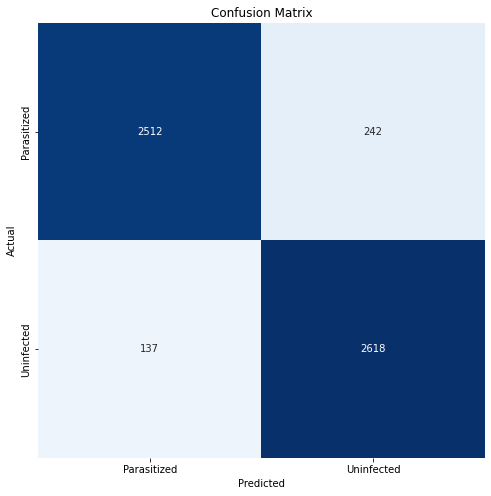



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.95      0.91      0.93      2754
  Uninfected       0.92      0.95      0.93      2755

    accuracy                           0.93      5509
   macro avg       0.93      0.93      0.93      5509
weighted avg       0.93      0.93      0.93      5509

Recall of the model is 0.95
Precision of the model is 0.92
F-1 Score of the model is 0.93


In [ ]:
evaluate(model2)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history2):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history2.history['accuracy']
  val_acc = history2.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy2 Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history2.history['loss']
  val_loss = history2.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  plt.savefig("Loss2 Plot.svg", format="svg", dpi=1200)

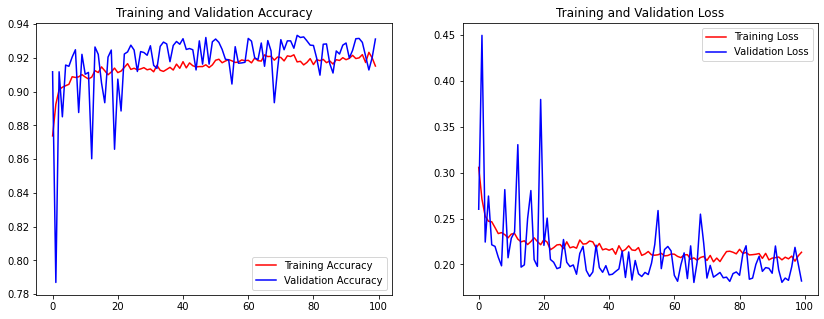

In [ ]:
eval_plot(history2)

In [ ]:
model2.save_weights("Model2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# serialize model to JSON
model2_json = model2.to_json()
with open("Model2.json", "w") as json_file: json_file.write(model2_json)

In [ ]:
# serialize weights to HDF5
model2.save("Model2.h5")
print("Saved model to disk")

Saved model to disk
